## Setup

In [1]:
import json
from pprint import pprint

import cifar100_helper  # local

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision

from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix,
                             ConfusionMatrixDisplay)

In [2]:
# Use this to view all the available models
# pprint(torch.hub.list("chenyaofo/pytorch-cifar-models", force_reload=True))
student_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=True)
teacher_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet56", pretrained=True)

Using cache found in /home/bruno/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/bruno/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [3]:
train_loader, test_load = cifar100_helper.cifar100("./", 32, None, None, batch_size=1000, num_workers=4, is_vit=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
idx_to_class = {v:k for k, v in train_loader.dataset.class_to_idx.items()}
idx_to_class_vec = np.array(list(idx_to_class.values()))

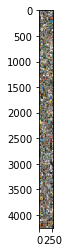

whale  rose   sea shrew tulip bicycle orchid table house cloud orchid   sea maple_tree   boy chair   sea   cup flatfish woman cloud woman plate palm_tree kangaroo   bed   man bottle  crab lobster possum  tank  wolf


In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % idx_to_class[labels[j].item()] for j in range(32)))

In [6]:
def print_acc(model, loader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print(f'Accuracy of the network on the {len(loader.dataset)} test images: %d %%' % (100 * correct / total))

In [7]:
# results for our model
# print("teacher model ", end="")
# print_acc(teacher_model, val_load)
# print("student model ", end="")
# print_acc(student_model, val_load)

In [8]:
# get some random test images
dataiter = iter(test_load)
images, labels = dataiter.next()

outputs = teacher_model(images)
_, predicted = torch.max(outputs, 1)

## Log results/metrics for this single batch 

Write metrics

In [9]:
results = classification_report(labels, predicted, output_dict=True)
results = {idx_to_class[int(k)]: v for k,v in results.items() if k.isnumeric()}

with open('metrics.json', 'w') as fp:
    json.dump(results, fp, sort_keys=True, indent=4)
    
with open('accuracy.json', 'w') as fp:
    json.dump({"accuracy": accuracy_score(labels, predicted)}, fp)

Write correlations

In [10]:
cm = pd.DataFrame(confusion_matrix(labels, predicted), columns=idx_to_class.values(), index=idx_to_class.values())
cm.to_json("confusion_matrix_100.json", indent=True)

Now for the 20 classes version correlation:

In [11]:
# from https://github.com/ryanchankh/cifar100coarse
def sparse2coarse(targets):
    """Convert Pytorch CIFAR100 sparse targets to coarse targets.
    Usage:
        trainset = torchvision.datasets.CIFAR100(path)
        trainset.targets = sparse2coarse(trainset.targets)
    """
    coarse_labels = np.array([ 4,  1, 14,  8,  0,  6,  7,  7, 18,  3,  
                               3, 14,  9, 18,  7, 11,  3,  9,  7, 11,
                               6, 11,  5, 10,  7,  6, 13, 15,  3, 15,  
                               0, 11,  1, 10, 12, 14, 16,  9, 11,  5, 
                               5, 19,  8,  8, 15, 13, 14, 17, 18, 10, 
                               16, 4, 17,  4,  2,  0, 17,  4, 18, 17, 
                               10, 3,  2, 12, 12, 16, 12,  1,  9, 19,  
                               2, 10,  0,  1, 16, 12,  9, 13, 15, 13, 
                              16, 19,  2,  4,  6, 19,  5,  5,  8, 19, 
                              18,  1,  2, 15,  6,  0, 17,  8, 14, 13])
    return coarse_labels[targets]

In [12]:
idx_to_class20 = {i:x for i,x in enumerate([
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables', 'household electrical devices', 'household furniture', 'insects', 
     'large carnivores', 'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores', 'medium-sized mammals', 'non-insect invertebrates', 
    'people', 'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2'
])}

In [13]:
cm = pd.DataFrame(confusion_matrix(sparse2coarse(labels), sparse2coarse(predicted)), columns=idx_to_class20.values(), index=idx_to_class20.values())
cm.to_json("confusion_matrix_20.json", indent=True)

In [15]:
%%javascript
$('#menubar').toggle();

<IPython.core.display.Javascript object>